*Universidade Federal de Ouro Preto
Departamento de Ciência da Computação
Programa de Pós-graduação em Ciência da Computação*
 
**Disciplina: Processamento Digital de Imagens (PCC144)**
**Prof. Dr. Guillermo Cámara Chávez**
**Aluna: Daniela Costa Terra**

*Trabalho prático: "Segmentação de Células a partir de Imagens Sintéticas de Citologia Cervical"*
*Julho/2022*

### Carrega pacotes

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
import pandas as pd

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


###Pré-processamento das imagens 
*Dataset: ISBI-2014 (https://cs.adelaide.edu.au/~carneiro/isbi14_challenge/dataset.*html*) 


**Pré-processamento: aumento de dados**

Aumento de dados feito separadamente conforme código **[AumentoDadosISBI2014.ipynb](https://drive.google.com/file/d/11AzvoZ0TIl2J498WzVVIvJMhoW2SvULa/view?usp=sharing)** 
- Descrição: a partir do conjunto de imagens de treinamento da base ISBI2014:  https://cs.adelaide.edu.au/~carneiro/isbi14_challenge/. Cada imagens gerou 20 aumentos considerando rotação, flip horizontal/vertical e crop aleatório.

*   trainX: conjunto de treinamento (945 imagens). Formato: 128 x 128 x 1
*   trainY: rótulos do conjunto de treinamento (945). Formato: 128 x 128 x 2 (2 canais: background(0) e foregroud(255)
*   valX: conjunto de validação (90 imagens originais da base). Formato: 128 x 128 x 1
*   valY: rótulos do conjunto de validação gerados a partir das máscaras da base original. Formato: 128 x 128 x 2 (2 canais: (background e foregroud)

Obs.: 


1.   As  máscaras são geradas pela extração do segundo canal de cada label em trainY e valY 
2.   trainISBI2014.csv e valISBI2014.csv: contém a lista dos arquivos (features,labels) para treino e validação
 


In [63]:
## Gunções usadas para aumento de dados:
def resize(image, mask, height, width):
  nimage = tf.image.resize(image, [height, width])
  nmask = tf.image.resize(mask, [height, width])
  return nimage, nmask

def random_crop(image, mask, height, width):
  stacked_image = tf.stack([image, mask], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, height, width, 1])
  return cropped_image[0], cropped_image[1]

def random_rot(image, mask):     # Angulo [90, 180, 270]
    kAngles = np.random.randint(1, high=4, dtype=int)
    nimage = tf.image.rot90(image, k =kAngles)
    nmask =  tf.image.rot90(mask, k= kAngles)
    return nimage, nmask

def random_jitter(image, mask):
  print('Jitter..')
  if tf.random.uniform(()) > 0.5:  
     # Random cropping  128x128
     hasMask = 0
     while(hasMask <= 20):
         nimage, nmask = random_crop(image, mask, 128, 128)
         hasMask = tf.math.reduce_sum(nmask)
     print('fez Crop')    
  else:
     nimage, nmask = resize(image, mask, 128, 128)    
     print('fez rezise')    
 
  if tf.random.uniform(()) > 0.5:  
     # Random mirroring rotate angle [90, 180, 270]
     nimage, nmask = random_rot(nimage, nmask)
     print('fez rot')    

  if tf.random.uniform(()) > 0.5:  
    # Random mirroring left_rigth
    nimage = tf.image.flip_left_right(nimage)
    nmask = tf.image.flip_left_right(nmask)
    print('fez flip LR')  
  else:
     # Random mirroring up_down
     nimage = tf.image.flip_up_down(nimage)
     nmask = tf.image.flip_up_down(nmask) 
     print('fez flip UD')  
      
  return nimage, nmask

###Arquivos de associação imagens/máscaras

In [64]:
# Pipeline para leitura de imagens

train_annot = pd.read_csv('/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/trainISBI2014.csv',header=0)
val_annot = pd.read_csv('/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/valISBI2014.csv',header=0)

#val_annot
train_annot 

,features,label
0,./trainX/SYN1.png,./trainY/SYN1_GT.png
1,./trainX/SYN10.png,./trainY/SYN10_GT.png
2,./trainX/SYN10_1.png,./trainY/SYN10_1_GT.png
3,./trainX/SYN10_10.png,./trainY/SYN10_10_GT.png
4,./trainX/SYN10_11.png,./trainY/SYN10_11_GT.png
...,...,...
940,./trainX/SYN9_5.png,./trainY/SYN9_5_GT.png
941,./trainX/SYN9_6.png,./trainY/SYN9_6_GT.png
942,./trainX/SYN9_7.png,./trainY/SYN9_7_GT.png
943,./trainX/SYN9_8.png,./trainY/SYN9_8_GT.png


In [65]:
OUTPUT_CHANNELS = 1
BUFFER_SIZE = 400
BATCH_SIZE = 16
 
IMG_WIDTH = 128
IMG_HEIGHT = 128

In [66]:
def adjustLabel(label):
    return np.abs(label-1)

In [67]:
train_datagen = ImageDataGenerator(rescale=1./255)
#trainY_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function= adjustLabel)

trainX_generator = train_datagen.flow_from_dataframe(dataframe=train_annot,
    directory='/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/', 
    class_mode=None, x_col='features', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

trainY_generator = train_datagen.flow_from_dataframe(dataframe=train_annot,
    directory='/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/', 
    class_mode= None, x_col='label', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE,shuffle=False)

train_generator = zip(trainX_generator, trainY_generator)

Found 945 validated image filenames.
Found 945 validated image filenames.


In [68]:
val_datagen = ImageDataGenerator(rescale=1./255)
#valY_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function= adjustLabel)

valX_generator = val_datagen.flow_from_dataframe(dataframe=val_annot,
    directory='/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/', 
    class_mode=None, x_col='features', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

valY_generator = val_datagen.flow_from_dataframe(dataframe=val_annot,
    directory='/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/dataset/', 
    class_mode=None, x_col='label', y_col=None, target_size=(IMG_HEIGHT, IMG_WIDTH),  color_mode= 'grayscale', batch_size=BATCH_SIZE, shuffle=False)

val_generator = zip(valX_generator, valY_generator)

Found 90 validated image filenames.
Found 90 validated image filenames.


In [141]:
#Testes carga imgs/masks
def show(image, label, pred=None):
  if  pred:
      _, axis = plt.subplots(1, 3, figsize=(9,5))
      axis[0].imshow(tf.squeeze(image), cmap='gray')
      axis[0].set_title("Imagem") 
      axis[1].imshow(tf.squeeze(label),  cmap='gray')
      axis[1].set_title("Máscara") 
      axis[2].imshow(tf.squeeze(label),  cmap='gray')
      axis[2].set_title("Predicao") 
      plt.axis('off')
      plt.show()    
  else:
      _, axis = plt.subplots(1, 2, figsize=(9,5))
      axis[0].imshow(tf.squeeze(image), cmap='gray')
      axis[0].set_title("Imagem") 
      axis[1].imshow(tf.squeeze(label),  cmap='gray')
      axis[1].set_title("Máscara") 
      plt.axis('off')
      plt.show()
 
      

*Teste carga datasets:*

In [142]:
# Exibindo conjunto de treino:
images= trainX_generator.next()
labels = trainY_generator.next()
show(images[0], labels[0])

FileNotFoundError: ignored

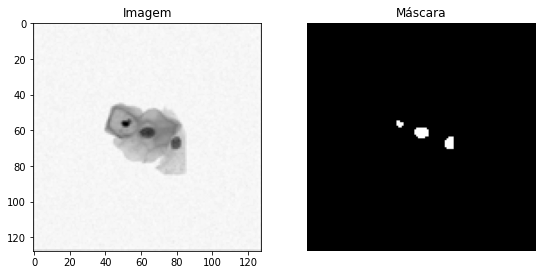

In [71]:
# Exibindo conjunto de validação:
sample_images = valX_generator.next()
sample_labels = valY_generator.next()
show(sample_images[0], sample_labels[0])

## Gera Modelo:  U-Net  ()

In [72]:
import tensorflow as tf

#from tensorflow.contrib.layers import xavier_initializer
#from tensorflow.contrib.layers.python.layers import layers as tf_layers

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

import numpy as np

## Modelo U-Net
Obs.: arquitetura de rede com blocos e camadas no mesmo formato original proposto por Ronneberger (2015): https://github.com/kimoktm/U-Net  

In [73]:
dropout_keep_prob = 0.3

## Convoluções Encoder/Decoder:
def conv_btn(filters, kernel, strides, apply_batchnorm=True, training=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, kernel, strides=strides, padding='same',
                             kernel_initializer=initializer))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.ReLU())
  return result


##Unet como classe

In [74]:
## U-NET Model, conforme modelo U-NET de Ronneberger(2015):
class Unet(Model):
  def __init__(self):
    super(Unet, self).__init__()
    self.inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    self.initializer = tf.random_normal_initializer(0., 0.02)
    # Encoder Section
    # Block 1   (128)
    conv1_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    conv1_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    self.block_1 = [conv1_1, conv1_2, pool1]

    # Block 2  (64)
    conv2_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    conv2_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    self.block_2 = [conv2_1, conv2_2, pool2]

    # Block 3  (32)
    conv3_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    conv3_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop3 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_3 = [conv3_1, conv3_2, pool3, drop3]

    # Block 4  (16)
    conv4_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    conv4_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop4 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_4 = [conv4_1, conv4_2, pool4, drop4]

    # Block 5  (8)
    conv5_1 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    conv5_2 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    drop5 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_5 = [conv5_1, conv5_2, drop5]

    # Decoder Section
    # Block 6   (8)
    upsample6 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (16)
    #concat6 = tf.keras.layers.concatenate([upsample6, conv4_2])  
    conv6_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    conv6_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    drop6 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_6 = [upsample6, None, conv6_1, conv6_2, drop6]

    # Block 7  (16)
    upsample7 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (32)
    #concat7 = tf.keras.layers.concatenate([upsample7, conv3_2])  
    conv7_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    conv7_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    drop7 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_7 = [upsample7, None, conv7_1, conv7_2, drop7]

    # Block 8  (32)
    upsample8 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (64)
    #concat8 = tf.keras.layers.concatenate([upsample8, conv2_2])  
    conv8_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    conv8_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    drop8 = tf.keras.layers.Dropout(dropout_keep_prob)
    self.block_8 = [upsample8, None, conv8_1, conv8_2, drop8]

    # Block 9 (64)
    upsample9 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (128)
    #concat9 = tf.keras.layers.concatenate([upsample9, conv1_2])  
    conv9_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    conv9_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    drop9 = tf.keras.layers.Dropout(dropout_keep_prob)
    
    # Block 9 output (conv 1x1)  (128)
    score9_1 = tf.keras.layers.Conv1D(2, 1, strides=1, activation='softmax')
    #score9_2 = tf.keras.layers.Reshape((-1, 128, 128, 1))
    self.block_9 = [upsample9, None, conv9_1, conv9_2, drop9, score9_1] 

  def call(self, x):
    # Downsampler:
    for i in range(3): # bloco 1 (128)
       x = self.block_1[i](x)
       if (i == 1):  ## salva para skip conection
          conv1_2 = x

    for i in range(3): # bloco 2  (64)
       x = self.block_2[i](x)
       if (i == 1):   ## salva para skip conection
          conv2_2 = x
    for i in range(4): # bloco 3  (32)
       x = self.block_3[i](x)
       if (i == 1):   ## salva para skip conection
          conv3_2 = x

    for i in range(4): # bloco 4  (16)
        x = self.block_4[i](x)
        if (i == 1):   ## salva para skip conection
            conv4_2 = x
            print("bloco 4: ", conv4_2.shape)
    
    for i in range(3): # bloco 5  (8)
        x = self.block_5[i](x)
    
    # Upsampler:

    for i in range(5): # bloco 6  (8)
        if (i == 1):   ## obtem skip conection do enconder conv4_2
           x = tf.keras.layers.concatenate([x, conv4_2])
           print("Bloco 6 if:", i, x.shape)  
        else: 
           print("Bloco 6 antes else:", i, x.shape)  
           x = self.block_6[i](x)    
           print("Bloco 6 else:", i, x.shape)  

    for i in range(5): # bloco 7
        if (i == 1):   ## obtem skip conection do enconder conv3_2
           x = tf.keras.layers.concatenate([x, conv3_2]) 
        else:   
           x = self.block_7[i](x)          

    for i in range(5):   # bloco 8
        if (i == 1):   ## obtem skip conection do enconder conv2_2
           x = tf.keras.layers.concatenate([x, conv2_2]) 
        else:   
           x = self.block_8[i](x)  

    for i in range(6): # bloco 9
        if (i == 1):   ## obtem skip conection do enconder conv1_2
           x = tf.keras.layers.concatenate([x, conv1_2]) 
        else:   
           x = self.block_9[i](x)        

    return x


##U-Net Model

In [75]:
def unet_model(output_channels):
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.layers.Input(shape=[128, 128, 1])
    x = inputs

  # Downsampling através do modelo
  # Block 1   (128) -> 64
    conv1_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    conv1_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)
    pool1 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    block_1 = [conv1_1, conv1_2, pool1]

    # Block 2  (64) -> 32
    conv2_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    conv2_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)
    pool2 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    block_2 = [conv2_1, conv2_2, pool2]

    # Block 3  (32) -> 16
    conv3_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    conv3_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)
    pool3 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop3 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_3 = [conv3_1, conv3_2, pool3, drop3]

    # Block 4  (16) -> 8
    conv4_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    conv4_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)
    pool4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=None, padding='same')
    drop4 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_4 = [conv4_1, conv4_2, pool4, drop4]

    # Block 5  (8)  
    conv5_1 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    conv5_2 = conv_btn(1024, 3, 1, apply_batchnorm=True, training=True)
    drop5 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_5 = [conv5_1, conv5_2, drop5]

    # Decoder Section
    # Block 6   (8) -> 16
    upsample6 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (16)
    #concat6 = tf.keras.layers.concatenate([upsample6, conv4_2])  
    conv6_1 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    conv6_2 = conv_btn(512, 3, 1, apply_batchnorm=True, training=True)  
    drop6 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_6 = [upsample6, None, conv6_1, conv6_2, drop6]

    # Block 7  (16) 
    upsample7 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (32)
    #concat7 = tf.keras.layers.concatenate([upsample7, conv3_2])  
    conv7_1 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    conv7_2 = conv_btn(256, 3, 1, apply_batchnorm=True, training=True)  
    drop7 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_7 = [upsample7, None, conv7_1, conv7_2, drop7]

    # Block 8  (32)
    upsample8 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (64)
    #concat8 = tf.keras.layers.concatenate([upsample8, conv2_2])  
    conv8_1 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    conv8_2 = conv_btn(128, 3, 1, apply_batchnorm=True, training=True)  
    drop8 = tf.keras.layers.Dropout(dropout_keep_prob)
    block_8 = [upsample8, None, conv8_1, conv8_2, drop8]

    # Block 9 (64)
    upsample9 = tf.keras.layers.UpSampling2D(size=(2, 2),  interpolation='bilinear')  # (128)
    #concat9 = tf.keras.layers.concatenate([upsample9, conv1_2])  
    conv9_1 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    conv9_2 = conv_btn(64, 3, 1, apply_batchnorm=True, training=True)  
    drop9 = tf.keras.layers.Dropout(dropout_keep_prob)
    
    # Block 9 output (conv 1x1)  (128)
    score9_1 = tf.keras.layers.Conv1D(1, 1, strides=1, activation='sigmoid')
    #score9_2 = tf.keras.layers.Reshape((-1, 128, 128, 1))
    block_9 = [upsample9, None, conv9_1, conv9_2, drop9, score9_1] 

    # Downsampler (Definição):
    for i in range(3): # bloco 1 (128)
       x = block_1[i](x)
       if (i == 1):  ## salva para skip conection
          conv1_2 = x

    for i in range(3): # bloco 2  (64)
       x = block_2[i](x)
       if (i == 1):   ## salva para skip conection
          conv2_2 = x
    for i in range(4): # bloco 3  (32)
       x = block_3[i](x)
       if (i == 1):   ## salva para skip conection
          conv3_2 = x

    for i in range(4): # bloco 4  (16)
        x = block_4[i](x)
        if (i == 1):   ## salva para skip conection
            conv4_2 = x
            #print("bloco 4: ", conv4_2.shape)
    
    for i in range(3): # bloco 5  (8)
        x = block_5[i](x)
    
    # Upsampler:

    for i in range(5): # bloco 6  (8)
        if (i == 1):   ## obtem skip conection do enconder conv4_2
           x = tf.keras.layers.concatenate([x, conv4_2])
           #print("Bloco 6 if:", i, x.shape)  
        else: 
           #print("Bloco 6 antes else:", i, x.shape)  
           x = block_6[i](x)    
           #print("Bloco 6 else:", i, x.shape)  

    for i in range(5): # bloco 7
        if (i == 1):   ## obtem skip conection do enconder conv3_2
           x = tf.keras.layers.concatenate([x, conv3_2]) 
        else:   
           x = block_7[i](x)          

    for i in range(5):   # bloco 8
        if (i == 1):   ## obtem skip conection do enconder conv2_2
           x = tf.keras.layers.concatenate([x, conv2_2]) 
        else:   
           x = block_8[i](x)  

    for i in range(6): # bloco 9
        if (i == 1):   ## obtem skip conection do enconder conv1_2
           x = tf.keras.layers.concatenate([x, conv1_2]) 
        else:   
           x = block_9[i](x)        
 
    return tf.keras.Model(inputs=inputs, outputs=x)

In [76]:
# Teste modelo Unet
model = unet_model(1)
x = tf.ones([1, 128, 128, 1], tf.float32)
model(x).shape 

TensorShape([1, 128, 128, 1])

In [77]:
#tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential_36 (Sequential)     (None, 128, 128, 64  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_37 (Sequential)     (None, 128, 128, 64  37184       ['sequential_36[0][0]']          
                                )                                                           

##Funções treinamento e métricas:


In [78]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [79]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

In [80]:
# Exibe predições durante treino
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], pred_mask[0]])
  else:
    display([sample_images[0], sample_labels[0],
             model.predict(sample_images)[0]])

In [82]:
## Exibição de imagen/mascara/predição
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nPredição após a época {}\n'.format(epoch+1))


In [119]:
# Exibe métricas de treino e validação ()
def plot_segm_history(history, title= "Métricas treino", metrics=["dice_coef", "val_dice_coef"], losses=["loss", "val_loss"]):
    """
    Args:
        history: dicionário retornado de fit model
        metrics:  lista de métricas para exibição treino/validação  
        losses: lista de estatic perdas para exibição treino/validação 
    """ 
    plt.figure(figsize=(10, 6))
    for metric in metrics:
        plt.plot(history.history[metric], linewidth=3)
    plt.suptitle("metrics over epochs", fontsize=20)
    plt.ylabel("metric", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0.3, 1, step=0.02), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(metrics, loc="center right", fontsize=15)
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(12, 6))
    for loss in losses:
        plt.plot(history.history[loss], linewidth=3)
    plt.suptitle("loss over epochs", fontsize=20)
    plt.ylabel("loss", fontsize=20)
    plt.xlabel("epoch", fontsize=20)
    # plt.yticks(np.arange(0, 0.2, step=0.005), fontsize=35)
    # plt.xticks(fontsize=35)
    plt.legend(losses, loc="center right", fontsize=15)
    plt.show()

In [83]:
## Binariza (ex.: uso para máscara predita)
def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [84]:
## Coeficiente de similaridade de DICE: também referido como Zijdenbos similarity index(ZSI) ou F1 Score
def dice_coef(y_true, y_pred, threshold=0.5, smooth=1.):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) /(
                tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

## DICE com limiar 
def dice_coef_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    intersection = tf.math.reduce_sum(y_true_f * y_pred_f)
    print(y_pred, int(intersection))
    return (2. * intersection + smooth) /(
                tf.math.reduce_sum(y_true_f) + tf.math.reduce_sum(y_pred_f) + smooth)

In [85]:
t = tf.constant([[1, 0], [1, 1], [0, 0], [0, 0]], dtype=tf.float32)
p = tf.constant([[0.5, 0], [0.4, 0.4], [0, 0], [0, 0]], dtype=tf.float32) 
dice_coef_thresholded(t, p)

tf.Tensor(
[[1. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32) 1


<tf.Tensor: shape=(), dtype=float32, numpy=0.6>

In [86]:
# Precisão: TPp/(TPp + FPp)
def precision_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred_f = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred_f, [-1])    
    inter = y_true_f * y_pred_f
    tp = tf.math.reduce_sum(y_true_f * y_pred_f)
    fp = tf.math.abs(tf.math.reduce_sum(y_pred_f - inter))
    return (tp /(tp + fp))

# Revocação: TPp/(TPp + FNp)
def recall_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])    
    inter = y_true_f * y_pred_f
    tp = tf.math.reduce_sum(y_true_f * y_pred_f)
    fn = tf.math.abs(tf.math.reduce_sum(y_true_f - inter)) 
    return (tp /(tp + fn))

In [87]:
t = tf.constant([[1, 0], [1, 1], [0, 0], [0, 0]], dtype=tf.float32)
p = tf.constant([[0.5, 0], [0.4, 0.4], [0, 0], [0, 0]], dtype=tf.float32) 
print(precision_thresholded(t, p))
print(precision_thresholded(t, p))
print(recall_thresholded(t, p))

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

##Treinamento do modelo: 

In [88]:
EPOCHS = 36
TRAIN_LENGTH = 945
BATCH_SIZE = 16
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
TRAIN_LENGTH, STEPS_PER_EPOCH
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 90//BATCH_SIZE
(TRAIN_LENGTH, STEPS_PER_EPOCH, VALIDATION_STEPS)

(945, 59, 5)

In [89]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints')

In [90]:
print(sys.path)

['/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints', '/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints', '', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython']


In [91]:
model_filename = "segm_unet_model_v0.h5"
checkpoint_path = os.path.join("training_0", model_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

In [92]:
from keras.callbacks import ModelCheckpoint

# Create a callback that saves the model's weights
callback_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

In [93]:
# Loss functio:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits= False)
# Otimizador:
optimizer_object = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [95]:
model.compile(optimizer= optimizer_object, loss= loss_object, metrics=['accuracy', dice_coef, dice_coef_thresholded])

###Treinamento inicial: (10 epócas)

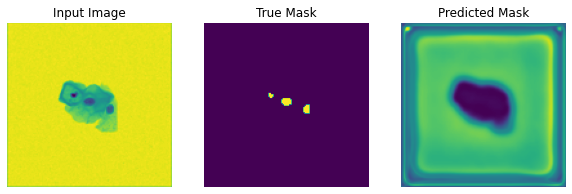


Predição após a época 10


Epoch 10: val_loss improved from 0.29784 to 0.22479, saving model to training_0/segm_unet_model_v0.h5
10/10 [==============================] - 371s 37s/step - loss: 0.0783 - accuracy: 0.9941 - dice_coef: 0.2196 - dice_coef_thresholded: 0.7779 - val_loss: 0.2248 - val_accuracy: 0.9900 - val_dice_coef: 0.0121 - val_dice_coef_thresholded: 7.8120e-04


In [96]:
# 10 épocas iniciais:
history_0 = model.fit(train_generator,
          steps_per_epoch= 10,
          epochs=10,
          initial_epoch=0,
          validation_steps=2,
          validation_data= val_generator,
          callbacks=[DisplayCallback(), callback_checkpoint])         

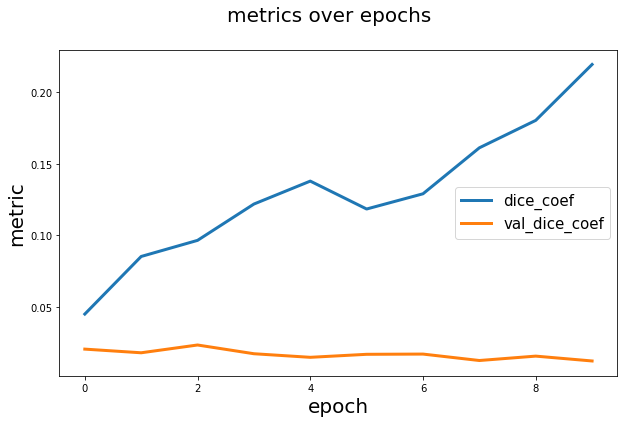

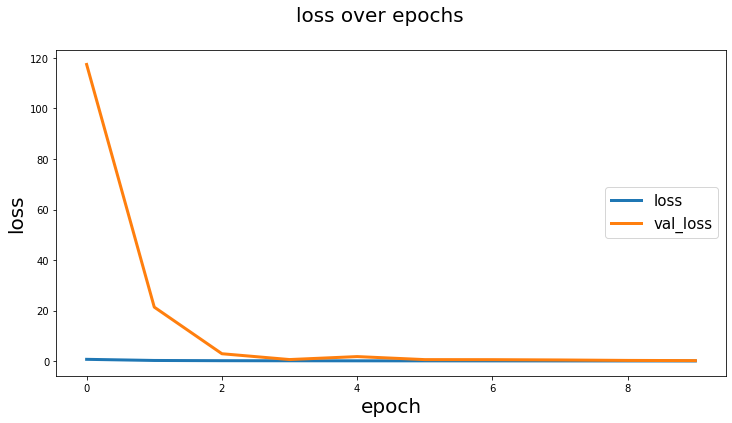

In [120]:
## Gráficos Treinamento (épocas 0 - 10):
plot_segm_history(history_0, title="Métricas - épocas: 0- 10")

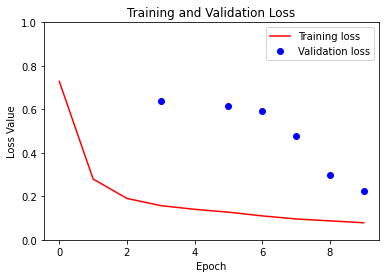

In [121]:
loss = history_0.history['loss']
val_loss = history_0.history['val_loss']
epochs = range(10)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

###Salva modelo (0 - 10 epócas)

In [123]:
model_filename = "segm_unet_model_v0.h5"
checkpoint_path = os.path.join("/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints/training_0", model_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

In [131]:
drive.flush_and_unmount()

In [124]:
model.save(checkpoint_path)


In [125]:
os.listdir(checkpoint_dir)

['segm_unet_model_v0.h5']

In [128]:
checkpoint_path_gdrive = "/content/drive/MyDrive/disciplinasDoutorado/PCC144-2022-1(PDI)/trabalho-parte3/checkpoints/training_1/"
checkpoint_dir_gdrive = os.path.dirname(checkpoint_path_gdrive)

In [130]:
os.listdir(checkpoint_dir_gdrive)

[]

##Treinamento: épocas 10 à 38:

In [142]:
model.load_weights(checkpoint_path)

In [25]:
model_filename = "segm_unet_model_v0.h5"
checkpoint_path = os.path.join("training_1", model_filename)
checkpoint_dir = os.path.dirname(checkpoint_path)

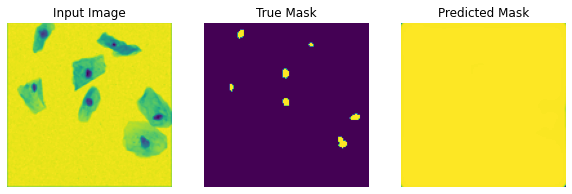


Predição após a época 40


Epoch 40: val_loss did not improve from 0.00532
59/59 [==============================] - 15s 253ms/step - loss: 0.0140 - accuracy: 0.9952 - val_loss: 22.9102 - val_accuracy: 0.0132


In [147]:
# Épocas de 10 à 26:
history_1 = model.fit(train_generator,
          steps_per_epoch= STEPS_PER_EPOCH,
          epochs=EPOCHS,
          initial_epoch=10,
          validation_steps=VALIDATION_STEPS,
          validation_data= val_generator,
          callbacks=[DisplayCallback(), callback_checkpoint])  

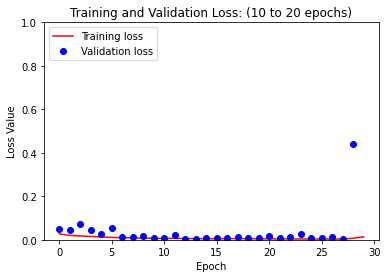

In [150]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(30)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Loss - treinamento e validação: (10 to 20 epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
## Gráficos Treinamento (épocas 0 - 10):
plot_segm_history(history_1, title="Métricas - épocas: 0- 10")

###Salva modelo (10 - 40 epócas)

In [ ]:
model.save(checkpoint_path)

In [ ]:
os.listdir(checkpoint_dir)

In [169]:
os.listdir(checkpoint_dir_gdrive)

['training_1']

## Avaliação do modelo treinado após 40 épocas:

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
 # Predição de 6 imagens da base de testes:
for i in range(6):
    show(sample_images[i], sample_labels[i], model.predict(model.predict(sample_images[i])))
 